In [1]:
!pip install --upgrade pandas-datareader

!pip install pandas-datareader

     |████████████████████████████████| 109 kB 731 kB/s            
     |████████████████████████████████| 12.0 MB 715 kB/s            
     |████████████████████████████████| 4.7 MB 564 kB/s            
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached numpy-1.24.2-cp310-cp310-macosx_10_9_x86_64.whl (19.8 MB)
     |████████████████████████████████| 502 kB 96 kB/s             
  Using cached urllib3-1.26.15-py2.py3-none-any.whl (140 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached charset_normalizer-3.1.0-cp310-cp310-macosx_10_9_x86_64.whl (124 kB)
You should consider upgrading via the '/Users/nico/PycharmProjects/AIAp-exercises/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nico/PycharmProjects/AIAp-exercises/venv/bin/python -m pip install --upgrade pip' command.


In [38]:
!pip install yfinance matplotlib scikit-learn numpy tensorflow

     |████████████████████████████████| 230.1 MB 47 kB/s              63.9 MB 4.4 MB/s eta 0:00:16 
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
     |████████████████████████████████| 397 kB 35.7 MB/s            
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
     |████████████████████████████████| 1.2 MB 25.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 440 kB 21.3 MB/s            
  Using cached h5py-3.8.0-cp310-cp310-macosx_10_9_x86_64.whl (3.2 MB)
  Using cached grpcio-1.51.3-cp310-cp310-macosx_12_0_universal2.whl (8.2 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     |████████████████████████████████| 26.7 MB 14.6 MB/s            
  Using cached tensorflow_io

# Reading data

Pandas datareader provides a function get_data_yahoo to directly fetch the stock data of the specified stock from Yahoo Finance for the given duration. WE are extracting the Netflix stock price between the duration from 2010-04-01 to 2022-04-25.

In [48]:
import pandas_datareader.data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
yf.pdr_override()
from datetime import datetime

In [1]:
df_netflix = pdr.get_data_yahoo('NFLX', datetime(1970, 1, 1))
df_netflix

NameError: name 'pdr' is not defined

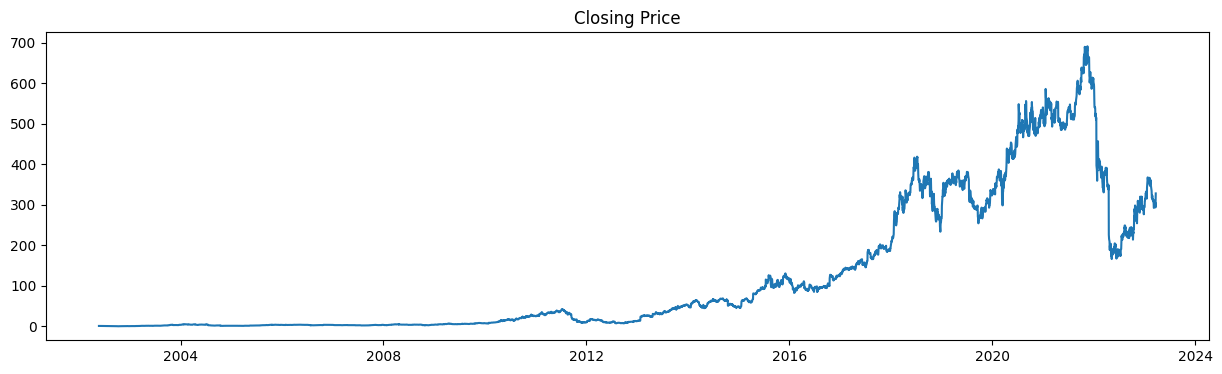

In [50]:
df = df_netflix['Close']
plt.figure(figsize = (15,4))
plt.plot(df)
plt.title("Closing Price")
plt.show()

# Dividing the dataset
Since this is time-series data, we cannot use the scikit-learn train_test_split() function because we need to preserve the order of prices. So, we will use, starting 80% of the values as a training dataset and the rest for testing. We also reshaped the datasets to make them compatible for the next step which is normalization. 

In [55]:
last_index = int(len(df) * 0.8)
train_complete = df[:last_index]

last_index_train = int(len(train_complete) * 0.8)
train = train_complete[:last_index_train].values.reshape(-1, 1)
validation = train_complete[last_index_train:].values.reshape(-1, 1)

test = df[last_index:].values.reshape(-1,1)

train.shape, validation.shape, test.shape

((3356, 1), (840, 1), (1050, 1))

# Normalization
Normalization converts all the values in the range of 0 to 1. It improves convergence and hence reduces training time.

In [56]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
validation = scaler.fit_transform(validation)
test = scaler.transform(test)

train[:10]

array([[0.00653229],
       [0.00663993],
       [0.00622068],
       [0.00579577],
       [0.00554083],
       [0.00558049],
       [0.00599406],
       [0.00590908],
       [0.00614137],
       [0.00641897]])

# Splitting the dataset into X and Y
This function specifies how many previous values must be considered to find out the pattern, in order to predict a price. Accordingly, both, the training and testing datasets are split into X and Y.

In [57]:
def create_dataset(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i + time_step), 0]   
    data_X.append(a)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

time_step = 100

X_train, y_train = create_dataset(train, time_step)
X_validation, y_validation = create_dataset(validation, time_step)

X_test, y_test = create_dataset(test, time_step)

In [58]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [73]:
from keras.models import Sequential
from keras.layers import Dense
 
model = Sequential([Dense(32, activation='relu', input_shape = [100,]),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)])
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                3232      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 100)

Epoch 1/100
102/102 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 2/100
102/102 [==============================] - 0s 3ms/step - loss: 8.1233e-04 - val_loss: 0.0043
Epoch 3/100
102/102 [==============================] - 0s 3ms/step - loss: 6.5594e-04 - val_loss: 0.0051
Epoch 4/100
102/102 [==============================] - 0s 3ms/step - loss: 5.3852e-04 - val_loss: 0.0025
Epoch 5/100
102/102 [==============================] - 0s 3ms/step - loss: 4.8646e-04 - val_loss: 0.0041
Epoch 6/100
102/102 [==============================] - 0s 3ms/step - loss: 5.0379e-04 - val_loss: 0.0027
Epoch 7/100
102/102 [==============================] - 0s 3ms/step - loss: 3.9906e-04 - val_loss: 0.0019
Epoch 8/100
102/102 [==============================] - 0s 3ms/step - loss: 3.8783e-04 - val_loss: 0.0038
Epoch 9/100
102/102 [==============================] - 0s 3ms/step - loss: 3.0454e-04 - val_loss: 0.0015
Epoch 10/100
102/102 [==============================] - 0s 

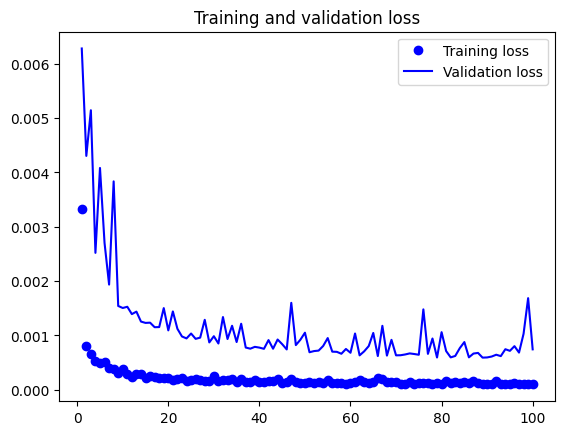

In [75]:
def plot_history(history):
    #acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    #plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    #plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(history)

In [76]:
test_predict = model.predict(X_test)
test_predict[:10]

30/30 [==============================] - 0s 2ms/step


array([[0.82441795],
       [0.8359078 ],
       [0.83832884],
       [0.8411739 ],
       [0.8648969 ],
       [0.8810475 ],
       [0.86996603],
       [0.86364466],
       [0.8820789 ],
       [0.8870212 ]], dtype=float32)

# Inversing Transformation
Since we normalized the data earlier and converted all the values in the range 0 to 1, now we should inverse the transformation to get actual values. 

In [77]:
test_predict=scaler.inverse_transform(test_predict)

# Visualizing the predictions
Here we have plotted actual and predicted stock prices for the test dataset. We can see that the model is performing fine.

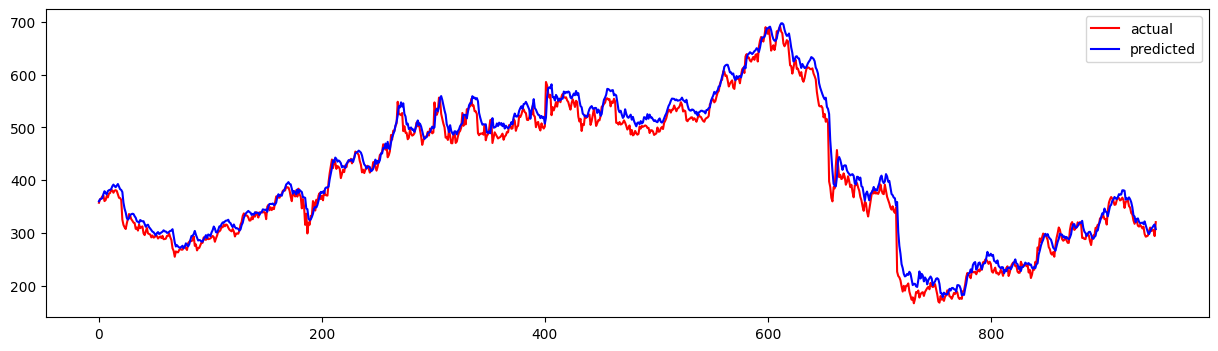

In [78]:
plt.figure(figsize = (15,4))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color = 'r', label = 'actual')
plt.plot(test_predict, color = 'b',label = 'predicted')
plt.legend()
plt.show()

# Evaluating model
For evaluation, we will be using root mean square values.

In [79]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,test_predict, squared = False)

437.4098001016384